---
title: "Ionosphere modelling with kriging"
bibliography: ../bibliography.bib
---

# Ionosphere modelling with kriging

In this guide, we will show you how to use the Kriging modules built into GNX-py to model the ionosphere. Kriging is a geostatistical method of spatial interpolation, thanks to which we can estimate the value of a given quantity in places not covered by measurements, based on a set of measured values in the vicinity of the point we are interested in. Kriging owes its effectiveness and popularity to the fact that it takes into account the spatial correlations of the measured samples, distance and direction between them. I will not derive equations for kriging here, as this goes beyond the scope of this tutorial to some extent. I encourage you to read publications: [@Sparks2011_KrigingIono; @Wielgosz2003_RegionalIonoMap] and materials on the internet, e.g.: [@Esri_KrigingHowWorks; @SemiExplained; @KrigingOverview]. I based my implementation mainly on these materials.

What do we actually gain from kriging in the context of ionosphere modelling? Let's start with the spatial resolution of the model. Empirical models such as NeQuick, Klobuchar or NTCM can, in theory, be densified at will, and there are no restrictions on generating a VTEC grid from such models. However, as you probably know, these models, although effective in navigation, are not very accurate. Assimilation models such as GIM are strongly based on measurements,however, the assumptions of the model, such as global and 24-hour coverage, mean that, however precise they may be, they have limitations when it comes to modelling local, short-term phenomena in the ionosphere.

Kriging offers two major advantages: we can obtain a modelled state of the ionosphere in a given area with a spatial resolution significantly higher than that of the GIM model and, at the same time, with a precision superior to empirical models, because we operate on real TEC measurements in a given epoch. The downside is that, unlike the techniques used in GIM, we do not have a tool for propagating our model over time, i.e. we use measurements from a given epoch to obtain a VTEC model/map for the same epoch. In addition, we have to operate with known DCBs of satellites and receivers, so we need external data sources or calibration. As I mentioned in the notebook dedicated to calibration, the optimal solution is to use the final GIM product for calibration, which is available with some delay. Spatial resolution is theoretically independent of the number of measurements, but in practice, the number of available measurements is important if we want to map conditions as close to reality as possible.

In previous guides, we discussed how to perform STEC measurements and calibration, and calculate ionospheric activity indices in GNX-py. In this notebook, we will use the data we used before to calculate the indices. The satellite DCB in this data comes from GIM, while the receiver DCB comes from the PPP-UDUC solution with ionospheric constraints from the GIM model. As we showed in the $calibration.py$ notebook, the receiver DCB obtained in this way should not have an error greater than 1 TECU. However, we ignore data where a negative STEC occurred somewhere after calibration, because this tells us that the calibration error is too large. In GNX-py, we have access to Ordinary Kriging, Universal Kriging, and Kriging based on the methodology described in [@Sparks2011_KrigingIono] In this guide, we will perform kriging on a given area and then compare the VTEC value between our model and  GIM and NTCM models.


In [40]:
import gps_lib as gnx
import numpy as np
import pandas as pd
import vtec_viz as vv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(
    "ignore",
    message="invalid value encountered in create_collection",
    category=RuntimeWarning,
    module="shapely.creation"
)


First, let us define a few parameters that control our code. $PLOT\_EVERY\_MIN$ is the time interval at which we want to generate VTEC snapshots. For simplicity and to save time, we will set this parameter to $60$ minutes. $R$ is the average radius of the Earth, and $ISH$ is the height of the ionospheric shell. These values are used to calculate the mapping function from STEC to VTEC. $zenith\_error$ is the measurement error of a single VTEC as a function of the zenith angle.

In [41]:
PLOT_EVERY_MIN = 60   # Produce map every 4 hours
R=6371 #km
ish = 450 #km
zenith_error = 1.5
def is_tick(ts: pd.Timestamp) -> bool:
    if PLOT_EVERY_MIN > 60:
        plot_every_h = PLOT_EVERY_MIN//60
        return (ts.second == 0) and (ts.hour % plot_every_h == 0) and (ts.minute == 0)
    else:
        return (ts.second == 0) and (ts.minute % PLOT_EVERY_MIN == 0)

Next, we set the path where our network measurements are located – these are the same files as in the case of index calculation. We also define the output path for saving our maps/models.

In [42]:
# I/O paths
path = './network'
out = './output'

Data loading and preparation is performed in the same way as for calculating ionospheric activity indices, which we discussed in the previous notebook.

In [43]:
df_all, sum  = gnx.load_stec_folder(folder=path,min_elev_deg=15,quiet=True)
m_f = 1 / np.sqrt(1 - (R / (R + ish)) ** 2 * np.cos(np.deg2rad(df_all['ev'])) ** 2)
df_all['mf'] = m_f
df_all['stec'] = df_all['leveled_tec']
df_all['vtec'] = df_all['stec'] / df_all['mf']
df_all = df_all.reset_index().copy()
df_all['sv'] = df_all['sv'].str[:3]
df_all = df_all[df_all['time'].dt.second % 30 == 0]
var = zenith_error / np.sin(np.deg2rad(df_all['ev'].values))
df_all['meas_var'] = var

Next, we will define the grid on which we will interpolate VTEC, as well as its spatial resolution. We select a grid over our area to enable comparison of the results at as many points as possible with values from the GIM model. We set the spatial resolution of the maps to $0.1$ x $0.1$ degrees.

In [44]:
# GRID definition
lat_min, lat_max = 47.5, 57.5 # 2.5 degrees resolution in latitude - 5 GIM points
lon_min, lon_max = 10, 30 # 5 degree resolution in longitude - 5 GIM points
lat_grid = np.arange(lat_min, lat_max, .1) # 0.1 degree x 0.1 degree spatial resolution
lon_grid = np.arange(lon_min, lon_max, .1)

The heart of the kriging module in GNX-py is the $IonoKrigingMonitor$ class. We will discuss its arguments and functionalities. Generally, you can perform kriging in three ways: using Ordinary Kriging, Universal Kriging, or the methodology described in [@Sparks2011_KrigingIono]. We will refer to these methodology as the Sparks methodology. All these methods are implemented in GNX-py. You can take snapshots in a geocentric or solar-geomagnetic coordinate system. In the latter system, you must substitute the epoch in UTC time into the class constructor, because the orientation of the system is practically constant during the day, whereas in contrast to ECEF, the positions of stations and IPPs in this system change from epoch to epoch. You can find more about the solar-geomagnetic system in [@KnechtShuman1985_GeomagneticField; @Mannucci1998].

When using the UK and OK methods, you can substitute your own variogram type and parameters. The Sparks methodology has its own unique parameters and separate variogram implementations. Optionally, you can set the default measurement variation if you have not defined it earlier in the input dataframe.

So, in the class constructor, you add:
- the lat/lon grid of your map
- the coordinate system: geocentric (GEO) or solar-geomagnetic (SM)
- SM system constructors: observation time (sm_obstime), which you must edit in each epoch, transformer from the GNX-py library (SolarGeomagneticTransformer)
- kriging method: UK, OK, or WAAS

For OK and UK methods:
-  type of variogram, variogram parameters (more about them in X and Y), and the number of nearest points for interpolation


For the WAAS methodology:

- the minimum and maximum radius in which IPPs are searched for in relation to a given IGP in order to estimate VTEC for it
- the target and minimum number of IPP points that
are needed to estimate TEC for a given IGP
- the type of variogram from the GNX-py library
- optionally, the variance of measurements





In [45]:
mon = gnx.IonoKrigingMonitor(
    grid_lon=lon_grid,
    grid_lat=lat_grid,

    # coordinate system of IGP and IPP
    coord_frame = "GEO"  ,         # "GEO" or "SM"

    # Parameters to use with Solar Geomagnetic frame
    sm_transformer = None ,     # SolarGeomagneticTransformer
    sm_obstime = None  ,    # astropy.Time (scalar)

    # Kriging method
    kriging_mode = "UK",

    # OK/UK method parameters
    variogram_model= "spherical",
    variogram_parameters={"sill": 7.0, "range": 1500.0, "nugget": 1},
    n_closest_points = 60,

    # WAAS/Spark method parameters
    Rmin_km= 800.0,
    Rmax_km= 2100.0,
    Ntarget = 30,
    Nmin = 10,

    # WAAS/Sparks: model variogramu
    variogram = gnx.SparksVariogram(),

    # WAAS/Sparks: wariancje szumów (opcjonalnie w df)
    default_meas_var= 2.0,
)

We prepare containers for storing epoch results and run kriging for our grid in a loop, providing measurements from a given epoch.

In [46]:
# df_all = df_all[(df_all['time'].dt.hour>=12) & (df_all['time'].dt.hour<=13)]  ## can be used to save time
# prepare input
df_all = df_all.sort_values("time")

times_all = []
V_all, SS_all, ROT_all, ROTI_all = [], [], [], []

# loop over epoch

for t, df_ep in df_all.groupby("time"):
    if is_tick(t):
        V, SS, info = mon.krige_epoch(df_ep, epoch_time=t)
        times_all.append(t)
        V_all.append(V.astype(np.float32))
        SS_all.append(SS.astype(np.float32))

ds = gnx.save_grids_to_netcdf(times=times_all,V_all=V_all,SS_All=SS_all,lat_grid=lat_grid,lon_grid=lon_grid,out_path=out,out_name='model')


The results are stored in xarray.Dataset format and saved in netCDF format. The variables stored in the dataset are V (VTEC) and SS (VTEC variance from kriging). The data is stored in $(time$ x $lat$ x $lon)$ format. GIM models are loaded into GNX-py in the same way. To display your model, you can use the $plot\_model$ function from the $vtec\_viz.py$ module that I have included for help in our tutorial.

In [47]:
print(ds.data_vars)

Data variables:
    V        (time, lat, lon) float32 2MB 11.18 11.21 11.23 ... 4.659 4.663
    SS       (time, lat, lon) float32 2MB 1.049 1.048 1.048 ... 1.05 1.05 1.05


In [48]:
list(ds.coords)


['time', 'lat', 'lon']

In [49]:
int(len(ds.time))

24

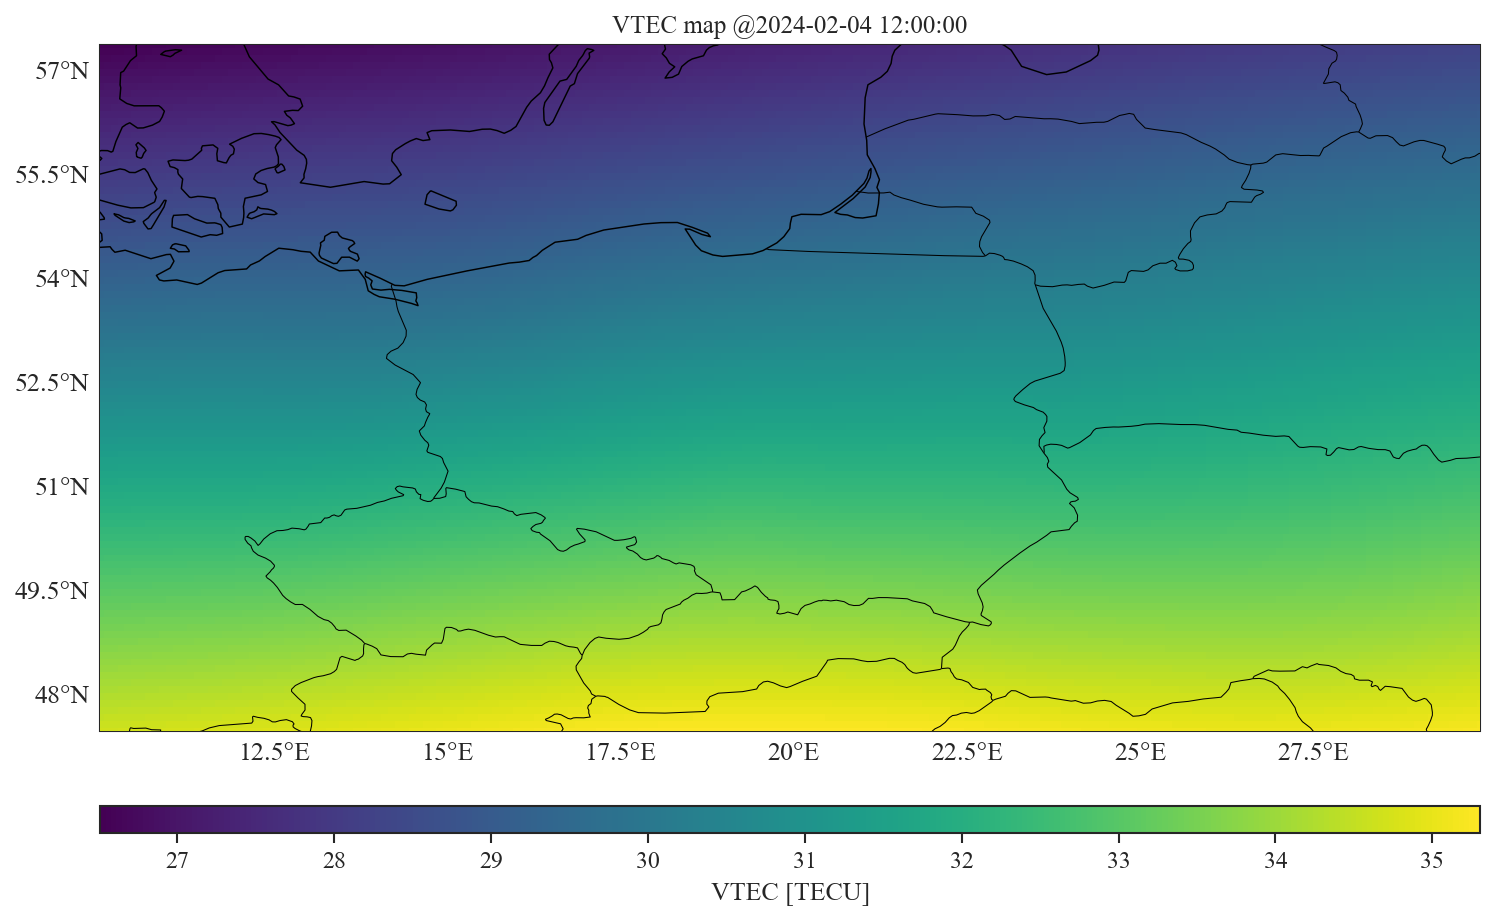

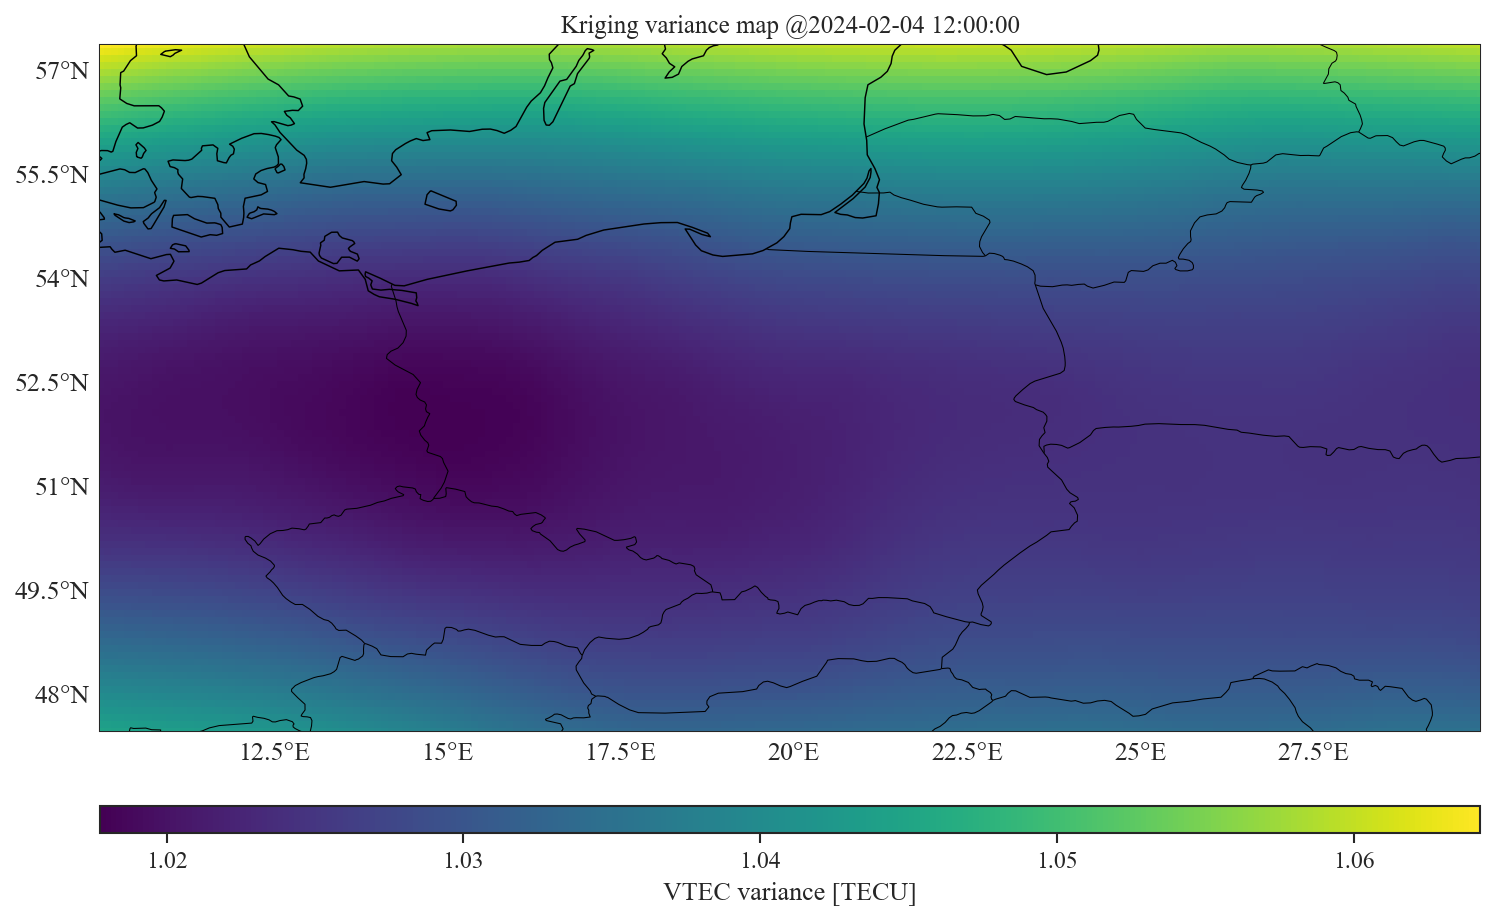

(<Figure size 1500x1500 with 2 Axes>,
 <GeoAxes: title={'center': 'Kriging variance map @2024-02-04 12:00:00'}>)

In [50]:
region = (10, 30, 50,57.5 )
model = "UK"
t_index =  int(len(ds.time)/2)
time = ds['time'][t_index].values
hh=pd.Timestamp(time).hour

vv.plot_model(
ds=ds,
var="V",
t_index=t_index,
cbar_orientation="horizontal",
cbar_location="bottom",
cbar_shrink=0.8,
cbar_aspect=40,
    cbar_label='VTEC [TECU]',
cbar_pad=0.0,
draw_coastlines=True,
figsize=(10,10),
cmap='viridis',
title=f'VTEC map @{pd.Timestamp(time)}',
savepath=f'{out}/{model}_MAP_{hh}.png')

vv.plot_model(
ds=ds,
var="SS",
t_index=t_index,
cbar_orientation="horizontal",
cbar_location="bottom",
cbar_shrink=0.8,
cbar_aspect=40,
    cbar_label='VTEC variance [TECU]',
cbar_pad=0.0,
draw_coastlines=True,
figsize=(10,10),
cmap='viridis',
title=f'Kriging variance map @{pd.Timestamp(time)}',
savepath=f'{out}/{model}_VAR_{hh}.png')



Let us compare our model with NTCM and GIM. It is worth recalling what we said at the beginning—the GIM has a relatively low spatial resolution compared to ours (0.1 x 0.1 degrees), so when comparing, we compare the values at five common points. First, let's load our IONEX file using GNX-py.

In [51]:
reader = gnx.GIMReader(tec_path='../data/COD0OPSFIN_20240350000_01D_01H_GIM.INX')
ionex = reader.read()
inx_tec=ionex.tec

To calculate TEC from the NTCM model, we need Galileo ionospheric model coefficients from navigation message.

In [52]:
nav='../data/BRDC00IGS_R_20240350000_01D_MN.rnx'
processor = gnx.GNSSDataProcessor2(nav_path=nav)
hdr = processor.nav_header_reader()
gal_alpha = hdr[-1]
gal_alpha

[152.0, -0.22656, -0.0070496]

We will now generate an NTCM grid corresponding to our Kriging grid. We will do this using the $compute\_ntcm\_grid$ function. The arguments are: the geocentric coordinate grid and the epoch list.

In [53]:
lat_grid = ds['V'].lat.values
lon_grid = ds['V'].lon.values
times    = ds.time.values

ds_ntcm = gnx.compute_ntcm_grid(lat_grid, lon_grid, times, gal_alpha=gal_alpha)

Datasets are convenient because the comparison will automatically take place at common points. I have prepared an auxiliary function $compare\_plot$ that allows us to compare TEC values between our models. Keep in mind that when comparing Kriging and GIM, my goal is not to show which model is “better” since they are produced using completely different methods. However, we will treat GIM as a reference and calculate the average TEC error in the area, assuming that the average TEC level should be similar.

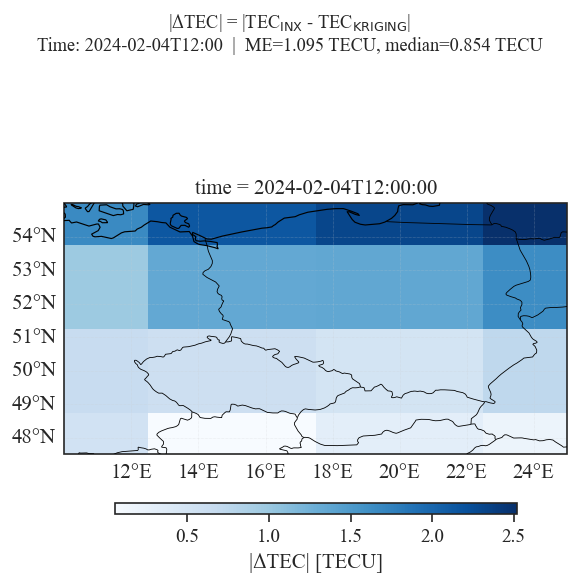

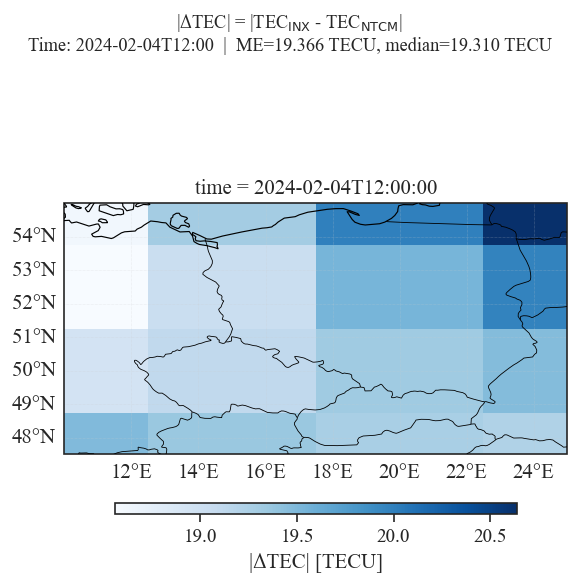

In [54]:
mns = []
mns_ntcm =[]
epochs = ds.time.values
for num, time in enumerate(ds.time.values):
    if num == len(epochs)/2:
        show=True
    else:
        show=False
    fig, ax, mean_abs, median_abs = vv.compare_plot(
        ds_model=ds,
        ds_ref=inx_tec,
        time=time,
        var_model="V",
        var_ref="TEC",
        cmap="Blues",
        cbar_orientation="horizontal",
        cbar_pad=0.1,
        cbar_shrink=0.8,
        cbar_aspect=40,
        figsize=(5,5),
        title_prefix = r"|ΔTEC| = |TEC$_\mathrm{INX}$ - TEC$_\mathrm{KRIGING}$|",
        show=show
    )
    mns.append(mean_abs)
    fig, ax, mean_abs, median_abs = vv.compare_plot(
        ds_model=ds_ntcm,
        ds_ref=inx_tec,
        time=time,
        var_model="V",
        var_ref="TEC",
        cmap="Blues",
        cbar_orientation="horizontal",
        cbar_pad=0.1,
        cbar_shrink=0.8,
        cbar_aspect=40,
        figsize=(5,5),
        title_prefix = r"|ΔTEC| = |TEC$_\mathrm{INX}$ - TEC$_\mathrm{NTCM}$|",
        show=show
    )
    mns_ntcm.append(mean_abs)


As you can see, the TEC differences between NTCM and GIM differ drastically from the differences between Kriging and GIM. I discussed some intuitions about the reasons for this at the beginning of this tutorial. Finally, let's plot the average error in each epoch on a common graph.

Text(0, 0.5, 'MAE [TECU]')

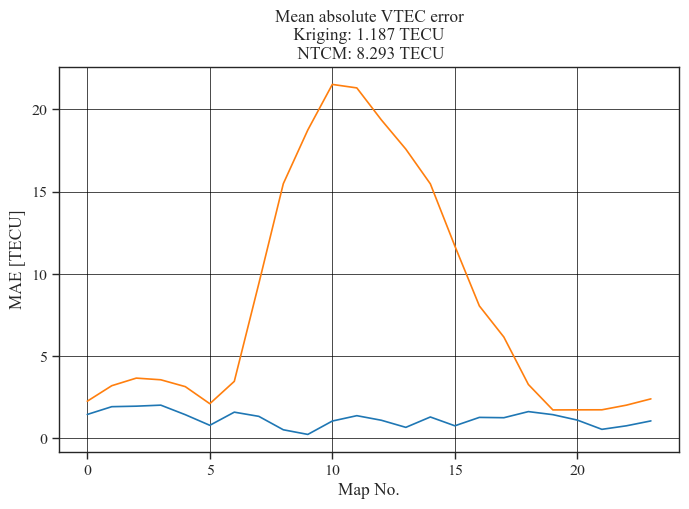

In [55]:
plt.figure(figsize=(8,5))
plt.title(f'Mean absolute VTEC error\n Kriging: {np.mean(np.asarray(mns)).round(3)} TECU \n NTCM: {np.mean(np.asarray(mns_ntcm)).round(3)} TECU')

plt.plot(range(len(mns)), mns,label='MAE for Kriging')
plt.plot(range(len(mns_ntcm)), mns_ntcm,label='MAE for NTCM')
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.xlabel('Map No.')
plt.ylabel('MAE [TECU]')


You already know how I use the Kriging module in GNX-py. Together with functions that calculate ionospheric activity indices, you can use kriging to monitor/visualize changes in electron concentration, e.g., during disturbances in the ionosphere. You already know the SPP and PPP modules – you can try to modify the code and connect the TEC model obtained by kriging to positioning and compare the results between the models. To do this, you need to have the modeled VTEC state for a given measurement epoch – you can obtain this by modifying the $PLOT\_EVERY\_MIN$ parameter.

The VTEC model generated using kriging is stored in xarray.Dataset format and saved in netcdf format. The file can be loaded using the $load\_dataset()$ function from xarray library. The xarray library offers a range of tools for data analysis, processing and visualisation and is quite convenient for grid data.